In [47]:
%load_ext autoreload
%autoreload 2
from configparser import ConfigParser
import topic_modeler.modeler
import topic_modeler.clustering
import topic_modeler.modeling
import topic_modeler.newsifier
import importlib
importlib.reload(topic_modeler.clustering)
importlib.reload(topic_modeler.modeling)
importlib.reload(topic_modeler.newsifier)
importlib.reload(topic_modeler.modeler)
from topic_modeler.modeler import Modeler
import json
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cfg = ConfigParser()
cfg.read('topic_modeler/settings.ini')
cluster_cfg = cfg['CLUSTERING']

In [48]:
modeler = Modeler()

In [ ]:
clf = Pipeline([
            ('tfidf', modeler.article_vectorizer),
            ('clf', modeler.classifier),
        ])
cluster_names = json.loads(cluster_cfg['CLUSTER_NAMES'])

In [ ]:
def sorted_cluster_predictions(text):
    return [
             { 'topic' : k,  'prob' : v } for k, v in sorted(
                { cluster_names[i] : x 
                                for i, x in enumerate(
                                    clf.predict_proba(
                                        [text]
                                    )[0]
                                ) 
                }.items(),
                key=lambda item: item[1],
                reverse=True)
    ]

import re
import requests
def predict_url(url):
    print(url)
    text = text_from_html(requests.get(url).content)
    formatted_predictor(text)
    
def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    return u" ".join(t.strip() for t in texts)


def formatted_predictor(text):
    ignore = ('Biology and Climate')
    general = ('General Climate')
    predictions = sorted_cluster_predictions(text)
    top = predictions.pop(0)
    while top['topic'] in ignore:
        top = predictions.pop(0)
    if (top['topic'] in general and top['prob'] < .32) or (top['prob'] < .1):
        print("This is probably not about climate.")
        print(f"(The best-scoring topic is {top['topic']} at {top['prob']:.2%})")
        return
    if top['prob'] > .9:
            print(f"This is almost definitely about {top['topic']} ({top['prob']:.2%}).")
    else:
        print(f"The best-scoring topic is {top['topic']} at {top['prob']:.2%}")
    top = predictions.pop(0)
    while top['prob'] > .05:
        if top['topic'] not in ignore:
            print(f"* {top['topic']} ({top['prob']:.2%})")
        top = predictions.pop(0)

In [69]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt

In [9]:
wc = WordCloud(background_color="white", max_words=5)

In [52]:
top_keywords = modeler.display_keyword_clusters(lower=True).T.head().T.head()

In [65]:
kdict = {k : int(v) for (k, v) in top_keywords[0].map(lambda x: re.search("^(.*) (\d+)$", x).group(1,2)).to_list()}

In [66]:
wc.generate_from_frequencies(kdict)

(-0.5, 399.5, 199.5, -0.5)

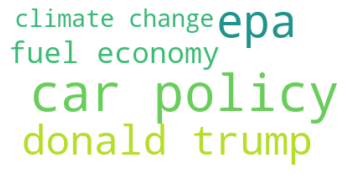

In [70]:
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

In [76]:
modeler.display_keyword_clusters(lower=True).T.head().T.head(19)

,0,1,2,3,4
0,car policy 9,water 25,endangered species 36,weather is happening 75,flint water crisis 37
1,epa 7,drought 14,conservation 11,weather 26,environmental justice 25
2,donald trump 6,climate change 8,science 7,climate 19,lead 21
3,fuel economy 4,science 8,animals 5,hurricane season 15,michigan 9
4,climate change 4,california 5,wildlife 4,climate change 10,flint water contamination 5
5,environment & climate 4,drinking water 3,poaching 3,hurricanes 10,flint michigan 5
6,tesla 4,south africa 3,rhinos 3,heat wave 8,flint mich. 4
7,trump 4,pollution 3,environment 3,snow 8,news 4
8,car technology 3,climate 3,extinction 3,typhoons 8,flint 4
9,environment 3,water wars 2,whales 2,wild weather 7,water 3


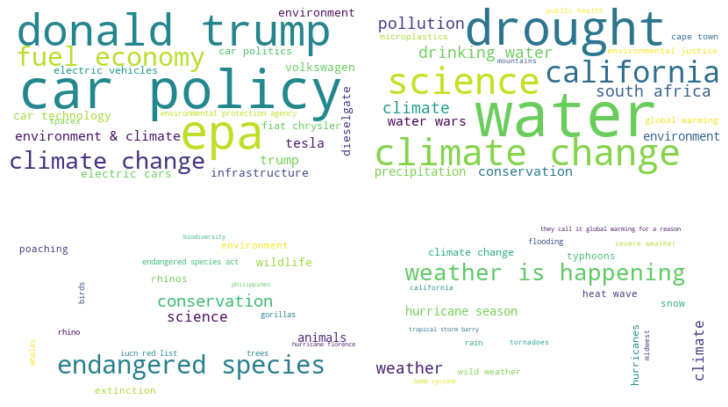

In [102]:
wc = WordCloud(background_color="white", max_words=19)
top_keywords = modeler.display_keyword_clusters(lower=True).T.head(4).T.head(19)
fig, axes =  plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(10,6))
axli = axes.flatten()
for i in range(top_keywords.shape[1]):
    kdict = {k : int(v) for (k, v) in top_keywords[i].map(lambda x: re.search("^(.*) (\d+)$", x).group(1,2)).to_list()}
    wc.generate_from_frequencies(kdict)
    axli[i].axis("off")
    axli[i].imshow(wc, interpolation="bilinear")
